In [13]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [14]:
df = pd.read_csv('./data/cookie_cats.csv')
df

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


### Objective
As players progress through the game they will encounter gates that force them to wait some time before they can progress or make an in-app purchase. In this project, we will analyze the result of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, we will analyze the impact on player retention and game rounds.

- userid - a unique number that identifies each player.
- version - whether the player was put in the control group (gate_30 - a gate at level 30) or the test group (gate_40 - a gate at level 40).
- sum_gamerounds - the number of game rounds played by the player during the first week after installation
- retention_1 - did the player come back and play 1 day after installing?
- retention_7 - did the player come back and play 7 days after installing?


### Hypothesis
 - There would exist optimal user level to apply Gate and we want find it out.
 - Which is better? 30 or 40? is what we want know and our assumption is that (at least) they are different (One of them is actually better)
 - 'Better' means it will retain player more.

### Need to be clarified
 - How many days/plays will a user need in order to reach 30/40 level in general? 
 - In order to aggregate 'retention_7', is there an upper limit? 7 days to ...upper limit?

In [15]:
df.groupby('version')[['userid']].count()

,userid
version,
gate_30,44700
gate_40,45489


In [16]:
df['retention_7_int'] = df['retention_7'].astype(int)
df.groupby('version')[['retention_7']].sum()

,retention_7
version,
gate_30,8502
gate_40,8279


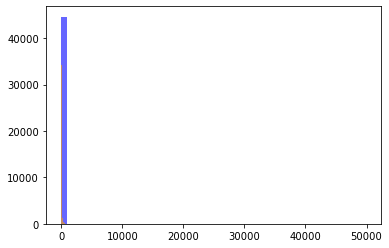

In [17]:
plt.hist(df[df['version']=='gate_30']['sum_gamerounds'], color='blue', alpha=0.6, bins=50)
plt.hist(df[df['version']=='gate_40']['sum_gamerounds'], color='orange', alpha=0.6, bins=50)
plt.show()

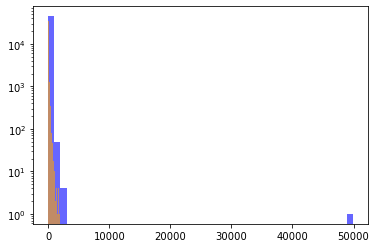

In [18]:
plt.hist(df[df['version']=='gate_30']['sum_gamerounds'], color='blue', alpha=0.6, bins=50, log=True)
plt.hist(df[df['version']=='gate_40']['sum_gamerounds'], color='orange', alpha=0.6, bins=50, log=True)
plt.show()

In [19]:
df.describe()

,userid,sum_gamerounds,retention_7_int
count,9.018900e+04,90189.000000,90189.000000
mean,4.998412e+06,51.872457,0.186065
std,2.883286e+06,195.050858,0.389161
min,1.160000e+02,0.000000,0.000000
25%,2.512230e+06,5.000000,0.000000
50%,4.995815e+06,16.000000,0.000000
75%,7.496452e+06,51.000000,0.000000
max,9.999861e+06,49854.000000,1.000000


In [20]:
df['sum_gamerounds'].quantile(.999999)

45624.81411590881

### Sanity check
 - Would 'sum_gamerounds' is same for A and B group?
 - Enough sample size for detecting MDE=2% with alpha=0.05, statistical power=0.8 ?

In [21]:
df['sum_gamerounds_log'] = np.log(df['sum_gamerounds'] + 1)
dfdummy = pd.get_dummies(df['version'], drop_first=True)
df['is_gete_40'] = dfdummy['gate_40']

In [22]:
import statsmodels.api as sm

X = df[['is_gete_40']]
X = sm.add_constant(X)

model = sm.OLS(df['sum_gamerounds_log'], X)
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     sum_gamerounds_log   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     3.291
Date:                Thu, 14 Apr 2022   Prob (F-statistic):             0.0697
Time:                        22:49:06   Log-Likelihood:            -1.6477e+05
No. Observations:               90189   AIC:                         3.295e+05
Df Residuals:                   90187   BIC:                         3.296e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8889      0.007    406.168      0.000       2.875       2.903
is_gete_40    -0.0182      0.010     -1.814      0.070      -0.038       0.001
==============================================================================
Omnibus:                     2851.380   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1443.736
Skew:                           0.105   Prob(JB):                         0.00
Kurtosis:                       2.417   Cond. No.                         2.63
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

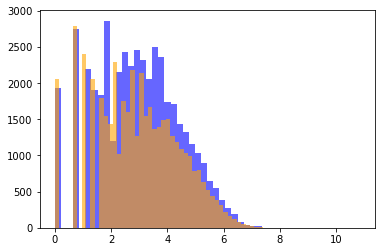

In [23]:
plt.hist(df[df['version']=='gate_30']['sum_gamerounds_log'], color='blue', alpha=0.6, bins=50)
plt.hist(df[df['version']=='gate_40']['sum_gamerounds_log'], color='orange', alpha=0.6, bins=50)
plt.show()

### Test with logistic regression

In [24]:
dfr7 = pd.get_dummies(df['retention_7'], drop_first=True)
df['is_retentioned_7'] = dfr7[True]
dfr1 = pd.get_dummies(df['retention_1'], drop_first=True)
df['is_retentioned_1'] = dfr1[True]

df.head()

,userid,version,sum_gamerounds,retention_1,retention_7,retention_7_int,sum_gamerounds_log,is_gete_40,is_retentioned_7,is_retentioned_1
0,116,gate_30,3,False,False,0,1.386294,0,0,0
1,337,gate_30,38,True,False,0,3.663562,0,0,1
2,377,gate_40,165,True,False,0,5.111988,1,0,1
3,483,gate_40,1,False,False,0,0.693147,1,0,0
4,488,gate_40,179,True,True,1,5.192957,1,1,1


In [25]:
X = df[['sum_gamerounds_log', 'is_retentioned_1', 'is_gete_40']]
X = sm.add_constant(X)

model = sm.Logit(df['is_retentioned_7'], X)
model = model.fit()
model.summary()

Optimization terminated successfully.
         Current function value: inf
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       is_retentioned_7   No. Observations:                90189
Model:                          Logit   Df Residuals:                    90185
Method:                           MLE   Df Model:                            3
Date:                Thu, 14 Apr 2022   Pseudo R-squ.:                     inf
Time:                        22:49:07   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -6.6012      0.047   -139.511      0.000      -6.694      -6.508
sum_gamerounds_log     1.4401      0.012    116.380      0.000       1.416       1.464
is_retentioned_1      -0.0666      0.026     -2.528      0.011      -0.118      -0.015
is_gete_40            -0.0818      0.022     -3.775      0.000      -0.124      -0.039
======================================================================================
"""

## Retention rate

In [26]:
dfgrp = df.groupby('version')[['retention_7', 'userid']].agg({
    'retention_7': 'sum',
    'userid': 'count'
})
dfgrp['retention_rate_7'] = dfgrp['retention_7'] / dfgrp['userid']
dfgrp = dfgrp.rename(columns={'retention_7': '# of retentioned users 7days', 'userid': '# of unique user'})
dfgrp

,# of retentioned users 7days,# of unique user,retention_rate_7
version,,,
gate_30,8502,44700,0.190201
gate_40,8279,45489,0.182000


## Chi-square test

In [27]:
from scipy.stats import chisquare, chi2_contingency
df_cross = pd.crosstab(index=df['version'], columns=df['retention_7'])
df_cross

retention_7,False,True
version,,
gate_30,36198,8502
gate_40,37210,8279


In [28]:
chisquare(df_cross)

Power_divergenceResult(statistic=array([13.95139494,  2.963411  ]), pvalue=array([0.0001876, 0.0851681]))

In [29]:
chi2_contingency(df_cross,correction=False)

(10.013167328688969,
 0.0015542499756142805,
 1,
 array([[36382.90257127,  8317.09742873],
        [37025.09742873,  8463.90257127]]))